In [1]:
import os
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [2]:
# Define dataset path
dataset_path = "/kaggle/input/wound-classification/Wound_dataset copy"

In [3]:
# Preprocess image
def preprocess_image(img):
    if img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (299, 299))  # Resize to 299x299
    img = img.astype('float32')
    img = preprocess_input(img)  # Preprocess for ResNet50
    return img

In [4]:
# Load and preprocess data
def load_data(data_path):
    data = []
    labels = []
    for folder in os.listdir(data_path):
        folder_path = os.path.join(data_path, folder)
        if os.path.isdir(folder_path):  # Ensure it's a directory
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                img = cv2.imread(file_path)
                if img is not None:  # Check if the image was loaded successfully
                    img = preprocess_image(img)  # Apply preprocessing to each image
                    data.append(img)
                    labels.append(folder)
    return np.array(data), np.array(labels)

In [5]:
from tensorflow.keras.applications.resnet50 import preprocess_input  # Import preprocess_input
# Load all data
X, y = load_data(dataset_path)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=len(label_encoder.classes_))

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [6]:
# Print shapes
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)

Training data shape: (2352, 299, 299, 3)
Validation data shape: (588, 299, 299, 3)
Training labels shape: (2352, 10)
Validation labels shape: (588, 10)


In [7]:
# Data Augmentation to reduce overfitting
datagen = ImageDataGenerator(
    rotation_range=30,  # Randomly rotate images by 30 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20%
    height_shift_range=0.2,  # Randomly shift images vertically by 20%
    shear_range=0.2,  # Apply shear transformations
    zoom_range=0.3,  # Randomly zoom in/out by 30%
    brightness_range=[0.7, 1.3],  # Randomly adjust brightness
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill missing pixels with the nearest value
)
datagen.fit(X_train)

In [8]:
# Build the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers[:-10]:  # Fine-tune more layers
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu', kernel_regularizer='l2'),  # Add L2 regularization
    Dropout(0.5),  # Add Dropout to reduce overfitting
    Dense(len(label_encoder.classes_), activation='softmax')  # Match number of classes
])

# Convert one-hot encoded labels back to integer labels
y_train_int = np.argmax(y_train, axis=1)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),  # Unique classes in the training set
    y=y_train_int  # Integer training labels
)
class_weights_dict = dict(enumerate(class_weights))  # Convert to dictionary

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)  # Reduce learning rate on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Early stopping to prevent overfitting

# Train the model with data augmentation
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),  # Use augmented data
    validation_data=(X_val, y_val),
    epochs=50,
    class_weight=class_weights_dict,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


74/74 ━━━━━━━━━━━━━━━━━━━━ 91s 915ms/step - accuracy: 0.2494 - loss: 10.6892 - val_accuracy: 0.6871 - val_loss: 8.9614 - learning_rate: 1.0000e-04
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 58s 718ms/step - accuracy: 0.6090 - loss: 9.0139 - val_accuracy: 0.8061 - val_loss: 8.3367 - learning_rate: 1.0000e-04
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 59s 724ms/step - accuracy: 0.7112 - loss: 8.4187 - val_accuracy: 0.8095 - val_loss: 8.0180 - learning_rate: 1.0000e-04
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 59s 722ms/step - accuracy: 0.7844 - loss: 8.0024 - val_accuracy: 0.8741 - val_loss: 7.5864 - learning_rate: 1.0000e-04
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 58s 709ms/step - accuracy: 0.8095 - loss: 7.5575 - val_accuracy: 0.8946 - val_loss: 7.2590 - learning_rate: 1.0000e-04
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 58s 712ms/step - accuracy: 0.8444 - loss: 7.1986 - val_accuracy: 0.9082 - val_loss: 6.9363 - learning_rate: 1.0000e-04
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 59s 720ms/step - accuracy: 0.8

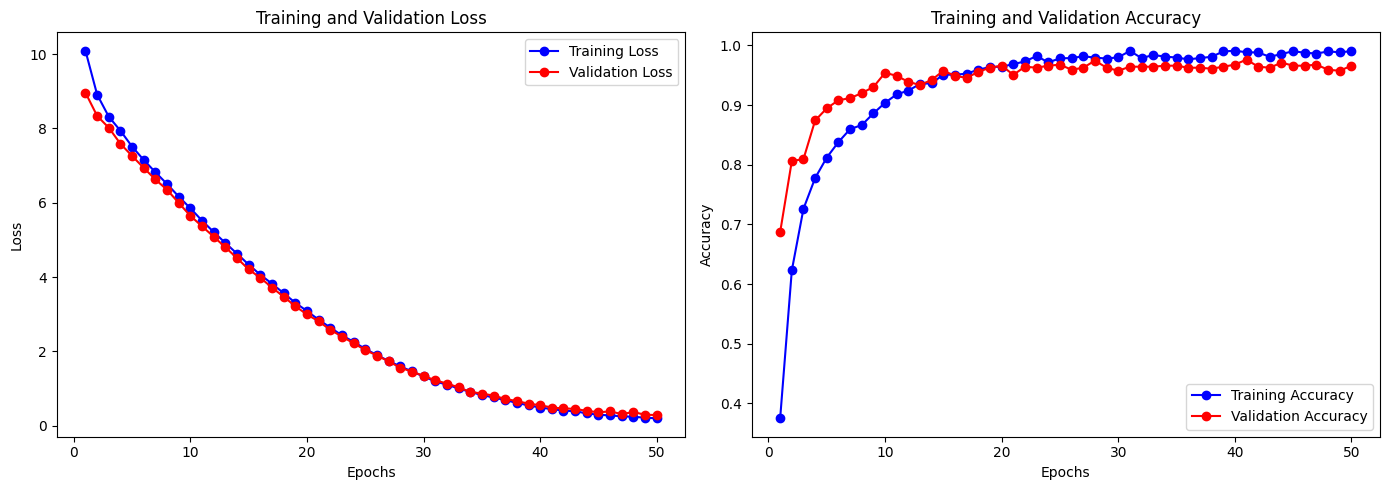

In [11]:
# Plot training and validation loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', marker='o', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict on the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Print classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 310ms/step
                 precision    recall  f1-score   support

      Abrasions       0.97      1.00      0.98        30
        Bruises       1.00      1.00      1.00        56
          Burns       0.89      1.00      0.94        25
            Cut       1.00      0.93      0.96        28
Diabetic Wounds       0.98      0.93      0.95        87
     Laseration       1.00      1.00      1.00        21
         Normal       0.98      0.92      0.95        52
Pressure Wounds       0.95      0.97      0.96       109
Surgical Wounds       0.95      0.96      0.96        82
  Venous Wounds       0.97      0.98      0.97        98

       accuracy                           0.97       588
      macro avg       0.97      0.97      0.97       588
   weighted avg       0.97      0.97      0.97       588



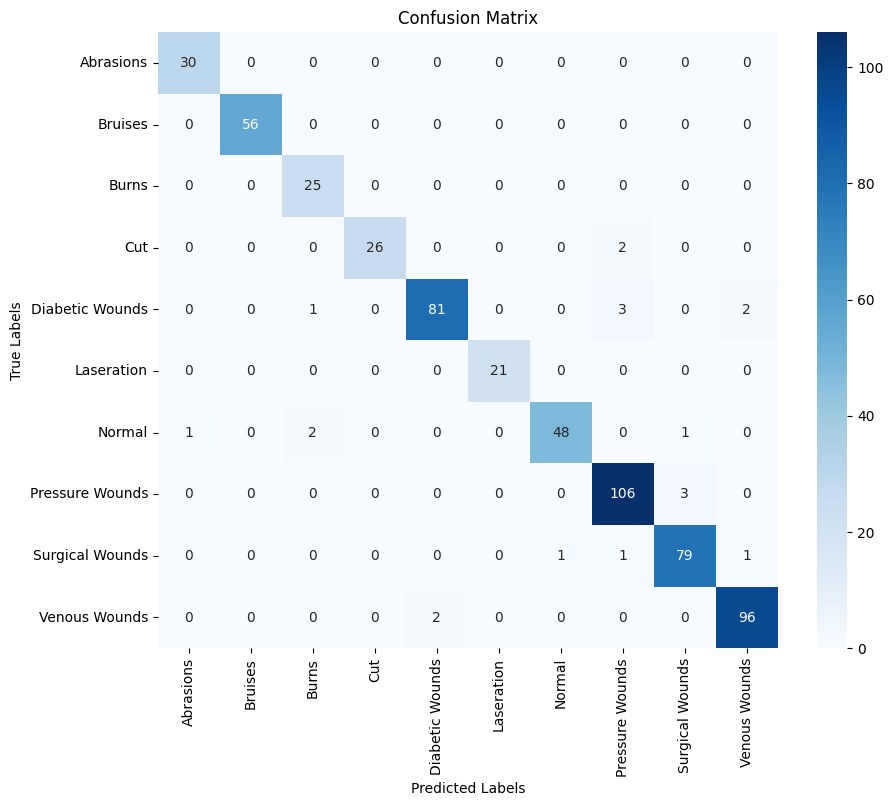

In [13]:
# Plot confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Save the model
model.save('wound_classification_model.h5')
print("Model saved as 'wound_classification_model.h5'")

Model saved as 'wound_classification_model.h5'


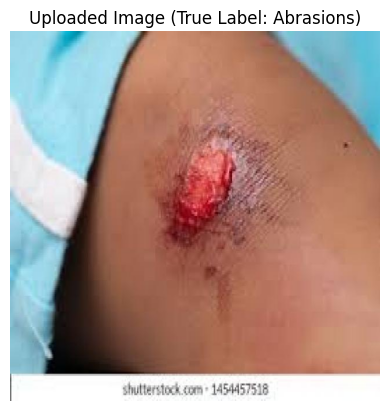

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
True Label: Abrasions
Predicted Label: Abrasions


In [15]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.preprocessing import LabelEncoder

# Define and fit LabelEncoder on the labels
le = LabelEncoder()
le.fit(y)  # y is the original labels of the dataset

# Function to preprocess the image
def preprocess_image(img):
    # Convert BGR to RGB for consistency
    if img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize the image to match the model's input size (299, 299 for ResNet50)
    img = cv2.resize(img, (299, 299))
    img = img.astype('float32')
    img = preprocess_input(img)  # Use preprocess_input based on the model
    return img

# Function to predict the class of an image
def predict_image_class(model, image_path, label_encoder):
    # Load the image
    img = cv2.imread(image_path)
    
    # Extract the true label from the image path
    true_label = image_path.split('/')[-2]  # Assumes the folder name is the true label
    
    # Check if the image was successfully loaded
    if img is None:
        print(f"Error: Unable to load the image at {image_path}")
        return
    
    # Display the uploaded image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    plt.axis('off')  # Hide axis
    plt.title(f"Uploaded Image (True Label: {true_label})")
    plt.show()

    # Preprocess the image and make a prediction
    img = preprocess_image(img)  # Apply preprocessing function
    img = np.expand_dims(img, axis=0)  # Add batch dimension for prediction

    # Make a prediction
    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions)
    predicted_label = label_encoder.classes_[predicted_class_index]

    # Print the true label and predicted label
    print(f'True Label: {true_label}')
    print(f'Predicted Label: {predicted_label}')

# Example usage
image_path = r'/kaggle/input/wound-classification/Wound_dataset copy/Abrasions/abrasions (10).jpg'  
predict_image_class(model, image_path, label_encoder)

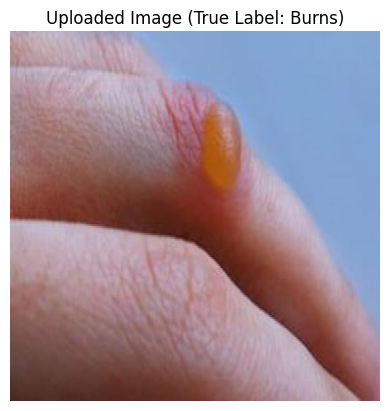

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
True Label: Burns
Predicted Label: Burns


In [16]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.preprocessing import LabelEncoder

# Define and fit LabelEncoder on the labels
le = LabelEncoder()
le.fit(y)  # y is the original labels of the dataset

# Function to preprocess the image
def preprocess_image(img):
    # Convert BGR to RGB for consistency
    if img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize the image to match the model's input size (299, 299 for ResNet50)
    img = cv2.resize(img, (299, 299))
    img = img.astype('float32')
    img = preprocess_input(img)  # Use preprocess_input based on the model
    return img

# Function to predict the class of an image
def predict_image_class(model, image_path, label_encoder):
    # Load the image
    img = cv2.imread(image_path)
    
    # Extract the true label from the image path
    true_label = image_path.split('/')[-2]  # Assumes the folder name is the true label
    
    # Check if the image was successfully loaded
    if img is None:
        print(f"Error: Unable to load the image at {image_path}")
        return
    
    # Display the uploaded image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    plt.axis('off')  # Hide axis
    plt.title(f"Uploaded Image (True Label: {true_label})")
    plt.show()

    # Preprocess the image and make a prediction
    img = preprocess_image(img)  # Apply preprocessing function
    img = np.expand_dims(img, axis=0)  # Add batch dimension for prediction

    # Make a prediction
    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions)
    predicted_label = label_encoder.classes_[predicted_class_index]

    # Print the true label and predicted label
    print(f'True Label: {true_label}')
    print(f'Predicted Label: {predicted_label}')

# Example usage
image_path = r'/kaggle/input/wound-dataset/Wound_dataset/Burns/burns (10).jpg'  
predict_image_class(model, image_path, label_encoder)

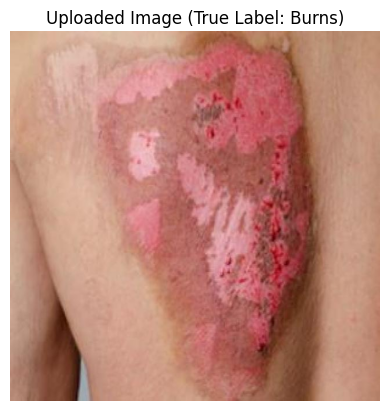

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
True Label: Burns
Predicted Label: Burns


In [17]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.preprocessing import LabelEncoder

# Define and fit LabelEncoder on the labels
le = LabelEncoder()
le.fit(y)  # y is the original labels of the dataset

# Function to preprocess the image
def preprocess_image(img):
    # Convert BGR to RGB for consistency
    if img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize the image to match the model's input size (299, 299 for ResNet50)
    img = cv2.resize(img, (299, 299))
    img = img.astype('float32')
    img = preprocess_input(img)  # Use preprocess_input based on the model
    return img

# Function to predict the class of an image
def predict_image_class(model, image_path, label_encoder):
    # Load the image
    img = cv2.imread(image_path)
    
    # Extract the true label from the image path
    true_label = image_path.split('/')[-2]  # Assumes the folder name is the true label
    
    # Check if the image was successfully loaded
    if img is None:
        print(f"Error: Unable to load the image at {image_path}")
        return
    
    # Display the uploaded image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    plt.axis('off')  # Hide axis
    plt.title(f"Uploaded Image (True Label: {true_label})")
    plt.show()

    # Preprocess the image and make a prediction
    img = preprocess_image(img)  # Apply preprocessing function
    img = np.expand_dims(img, axis=0)  # Add batch dimension for prediction

    # Make a prediction
    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions)
    predicted_label = label_encoder.classes_[predicted_class_index]

    # Print the true label and predicted label
    print(f'True Label: {true_label}')
    print(f'Predicted Label: {predicted_label}')

# Example usage
image_path = r'/kaggle/input/wound-dataset/Wound_dataset/Burns/burns (23).jpg'  
predict_image_class(model, image_path, label_encoder)

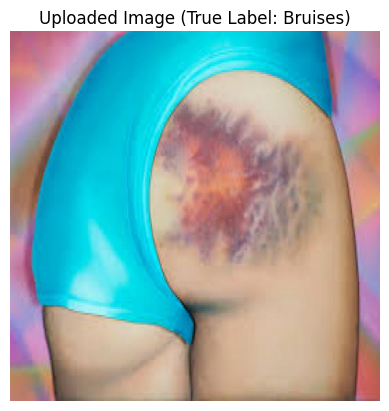

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
True Label: Bruises
Predicted Label: Bruises


In [18]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.preprocessing import LabelEncoder

# Define and fit LabelEncoder on the labels
le = LabelEncoder()
le.fit(y)  # y is the original labels of the dataset

# Function to preprocess the image
def preprocess_image(img):
    # Convert BGR to RGB for consistency
    if img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize the image to match the model's input size (299, 299 for ResNet50)
    img = cv2.resize(img, (299, 299))
    img = img.astype('float32')
    img = preprocess_input(img)  # Use preprocess_input based on the model
    return img

# Function to predict the class of an image
def predict_image_class(model, image_path, label_encoder):
    # Load the image
    img = cv2.imread(image_path)
    
    # Extract the true label from the image path
    true_label = image_path.split('/')[-2]  # Assumes the folder name is the true label
    
    # Check if the image was successfully loaded
    if img is None:
        print(f"Error: Unable to load the image at {image_path}")
        return
    
    # Display the uploaded image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    plt.axis('off')  # Hide axis
    plt.title(f"Uploaded Image (True Label: {true_label})")
    plt.show()

    # Preprocess the image and make a prediction
    img = preprocess_image(img)  # Apply preprocessing function
    img = np.expand_dims(img, axis=0)  # Add batch dimension for prediction

    # Make a prediction
    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions)
    predicted_label = label_encoder.classes_[predicted_class_index]

    # Print the true label and predicted label
    print(f'True Label: {true_label}')
    print(f'Predicted Label: {predicted_label}')

# Example usage
image_path = r'/kaggle/input/wound-dataset/Wound_dataset/Bruises/bruises (103).jpg'  
predict_image_class(model, image_path, label_encoder)

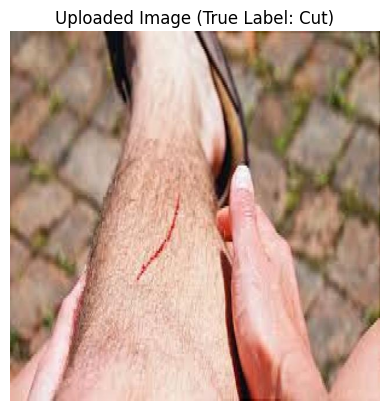

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
True Label: Cut
Predicted Label: Cut


In [19]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.preprocessing import LabelEncoder

# Define and fit LabelEncoder on the labels
le = LabelEncoder()
le.fit(y)  # y is the original labels of the dataset

# Function to preprocess the image
def preprocess_image(img):
    # Convert BGR to RGB for consistency
    if img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize the image to match the model's input size (299, 299 for ResNet50)
    img = cv2.resize(img, (299, 299))
    img = img.astype('float32')
    img = preprocess_input(img)  # Use preprocess_input based on the model
    return img

# Function to predict the class of an image
def predict_image_class(model, image_path, label_encoder):
    # Load the image
    img = cv2.imread(image_path)
    
    # Extract the true label from the image path
    true_label = image_path.split('/')[-2]  # Assumes the folder name is the true label
    
    # Check if the image was successfully loaded
    if img is None:
        print(f"Error: Unable to load the image at {image_path}")
        return
    
    # Display the uploaded image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    plt.axis('off')  # Hide axis
    plt.title(f"Uploaded Image (True Label: {true_label})")
    plt.show()

    # Preprocess the image and make a prediction
    img = preprocess_image(img)  # Apply preprocessing function
    img = np.expand_dims(img, axis=0)  # Add batch dimension for prediction

    # Make a prediction
    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions)
    predicted_label = label_encoder.classes_[predicted_class_index]

    # Print the true label and predicted label
    print(f'True Label: {true_label}')
    print(f'Predicted Label: {predicted_label}')

# Example usage
image_path = r'/kaggle/input/wound-dataset/Wound_dataset/Cut/cut (16).jpg'  
predict_image_class(model, image_path, label_encoder)

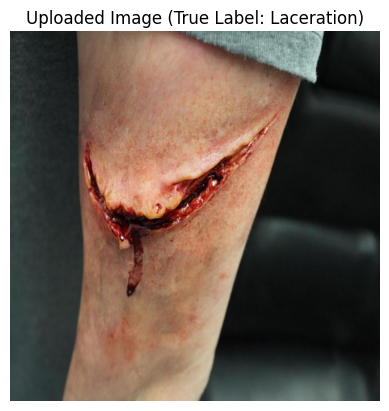

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
True Label: Laceration
Predicted Label: Laseration


In [20]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.preprocessing import LabelEncoder

# Define and fit LabelEncoder on the labels
le = LabelEncoder()
le.fit(y)  # y is the original labels of the dataset

# Function to preprocess the image
def preprocess_image(img):
    # Convert BGR to RGB for consistency
    if img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize the image to match the model's input size (299, 299 for ResNet50)
    img = cv2.resize(img, (299, 299))
    img = img.astype('float32')
    img = preprocess_input(img)  # Use preprocess_input based on the model
    return img

# Function to predict the class of an image
def predict_image_class(model, image_path, label_encoder):
    # Load the image
    img = cv2.imread(image_path)
    
    # Extract the true label from the image path
    true_label = image_path.split('/')[-2]  # Assumes the folder name is the true label
    
    # Check if the image was successfully loaded
    if img is None:
        print(f"Error: Unable to load the image at {image_path}")
        return
    
    # Display the uploaded image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    plt.axis('off')  # Hide axis
    plt.title(f"Uploaded Image (True Label: {true_label})")
    plt.show()

    # Preprocess the image and make a prediction
    img = preprocess_image(img)  # Apply preprocessing function
    img = np.expand_dims(img, axis=0)  # Add batch dimension for prediction

    # Make a prediction
    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions)
    predicted_label = label_encoder.classes_[predicted_class_index]

    # Print the true label and predicted label
    print(f'True Label: {true_label}')
    print(f'Predicted Label: {predicted_label}')

# Example usage
image_path = r'/kaggle/input/wound-dataset/Wound_dataset/Laceration/laseration (16).jpg'  
predict_image_class(model, image_path, label_encoder)

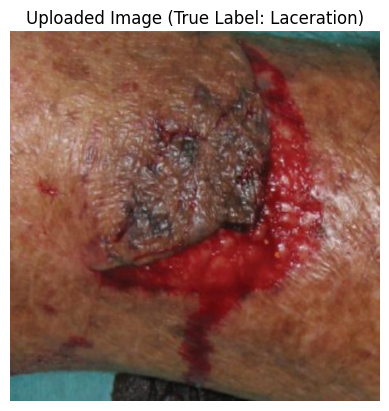

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
True Label: Laceration
Predicted Label: Laseration


In [21]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.preprocessing import LabelEncoder

# Define and fit LabelEncoder on the labels
le = LabelEncoder()
le.fit(y)  # y is the original labels of the dataset

# Function to preprocess the image
def preprocess_image(img):
    # Convert BGR to RGB for consistency
    if img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize the image to match the model's input size (299, 299 for ResNet50)
    img = cv2.resize(img, (299, 299))
    img = img.astype('float32')
    img = preprocess_input(img)  # Use preprocess_input based on the model
    return img

# Function to predict the class of an image
def predict_image_class(model, image_path, label_encoder):
    # Load the image
    img = cv2.imread(image_path)
    
    # Extract the true label from the image path
    true_label = image_path.split('/')[-2]  # Assumes the folder name is the true label
    
    # Check if the image was successfully loaded
    if img is None:
        print(f"Error: Unable to load the image at {image_path}")
        return
    
    # Display the uploaded image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    plt.axis('off')  # Hide axis
    plt.title(f"Uploaded Image (True Label: {true_label})")
    plt.show()

    # Preprocess the image and make a prediction
    img = preprocess_image(img)  # Apply preprocessing function
    img = np.expand_dims(img, axis=0)  # Add batch dimension for prediction

    # Make a prediction
    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions)
    predicted_label = label_encoder.classes_[predicted_class_index]

    # Print the true label and predicted label
    print(f'True Label: {true_label}')
    print(f'Predicted Label: {predicted_label}')

# Example usage
image_path = r'/kaggle/input/wound-dataset/Wound_dataset/Laceration/laseration (24).jpg'  
predict_image_class(model, image_path, label_encoder)

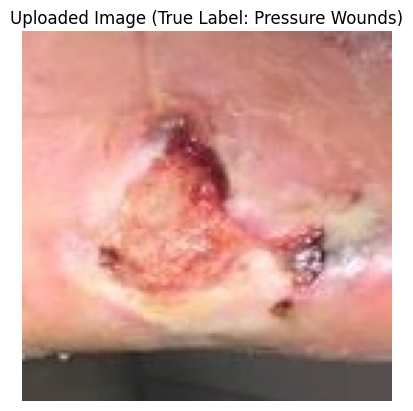

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
True Label: Pressure Wounds
Predicted Label: Pressure Wounds


In [22]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.preprocessing import LabelEncoder

# Define and fit LabelEncoder on the labels
le = LabelEncoder()
le.fit(y)  # y is the original labels of the dataset

# Function to preprocess the image
def preprocess_image(img):
    # Convert BGR to RGB for consistency
    if img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize the image to match the model's input size (299, 299 for ResNet50)
    img = cv2.resize(img, (299, 299))
    img = img.astype('float32')
    img = preprocess_input(img)  # Use preprocess_input based on the model
    return img

# Function to predict the class of an image
def predict_image_class(model, image_path, label_encoder):
    # Load the image
    img = cv2.imread(image_path)
    
    # Extract the true label from the image path
    true_label = image_path.split('/')[-2]  # Assumes the folder name is the true label
    
    # Check if the image was successfully loaded
    if img is None:
        print(f"Error: Unable to load the image at {image_path}")
        return
    
    # Display the uploaded image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    plt.axis('off')  # Hide axis
    plt.title(f"Uploaded Image (True Label: {true_label})")
    plt.show()

    # Preprocess the image and make a prediction
    img = preprocess_image(img)  # Apply preprocessing function
    img = np.expand_dims(img, axis=0)  # Add batch dimension for prediction

    # Make a prediction
    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions)
    predicted_label = label_encoder.classes_[predicted_class_index]

    # Print the true label and predicted label
    print(f'True Label: {true_label}')
    print(f'Predicted Label: {predicted_label}')

# Example usage
image_path = r'/kaggle/input/wound-classification/Wound_dataset copy/Pressure Wounds/13_0.jpg'  
predict_image_class(model, image_path, label_encoder)

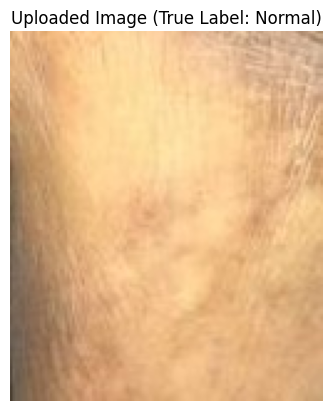

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
True Label: Normal
Predicted Label: Normal


In [23]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.preprocessing import LabelEncoder

# Define and fit LabelEncoder on the labels
le = LabelEncoder()
le.fit(y)  # y is the original labels of the dataset

# Function to preprocess the image
def preprocess_image(img):
    # Convert BGR to RGB for consistency
    if img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize the image to match the model's input size (299, 299 for ResNet50)
    img = cv2.resize(img, (299, 299))
    img = img.astype('float32')
    img = preprocess_input(img)  # Use preprocess_input based on the model
    return img

# Function to predict the class of an image
def predict_image_class(model, image_path, label_encoder):
    # Load the image
    img = cv2.imread(image_path)
    
    # Extract the true label from the image path
    true_label = image_path.split('/')[-2]  # Assumes the folder name is the true label
    
    # Check if the image was successfully loaded
    if img is None:
        print(f"Error: Unable to load the image at {image_path}")
        return
    
    # Display the uploaded image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    plt.axis('off')  # Hide axis
    plt.title(f"Uploaded Image (True Label: {true_label})")
    plt.show()

    # Preprocess the image and make a prediction
    img = preprocess_image(img)  # Apply preprocessing function
    img = np.expand_dims(img, axis=0)  # Add batch dimension for prediction

    # Make a prediction
    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions)
    predicted_label = label_encoder.classes_[predicted_class_index]

    # Print the true label and predicted label
    print(f'True Label: {true_label}')
    print(f'Predicted Label: {predicted_label}')

# Example usage
image_path = r'/kaggle/input/wound-classification/Wound_dataset copy/Normal/2.jpg'  
predict_image_class(model, image_path, label_encoder)